# Импортируем необходимые библиотеки 

In [7]:
import json
import pandas as pd
import re
import random
import time
import numpy as np
import nltk
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

######## METRICS
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# matplotlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Функции, которые будут использоваться:
    - preprocess_reviews - для удаления из отзывов всех лишних символов
    - lemmatize - для лемматизации слов

In [8]:
from nltk import word_tokenize   
from nltk.stem import WordNetLemmatizer



from nltk.stem import PorterStemmer
porter = PorterStemmer()



class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [19]:


print(porter.stem("enjoyed"))

lemmatize("enjoyed")

enjoy


'enjoy'

In [29]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
stop_words = stopwords.words('english')
def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    return reviews
def lemmatize(str_):
    lst = str_.split(" ")
    lst_new = []
    for i in lst:
        if i not in stop_words:     
            new = porter.stem(i)
#             print (i, new)
            lst_new.append (new)
    return ' '.join(lst_new)

# Главная функция (classify_it), в которую подставляется месторасположение файлов.

In [32]:
from sklearn.utils import shuffle

def prepare_dataset(filename):
    i = 0
    reviews_lst_good= []
    reviews_lst_bad = []

    #набираем список хороших/плохих отзывов, не более 75000 в каждом из списков
    with open(filename, 'r') as f:
            for line in f:
                if json.loads(line)['overall'] > 3 and len(reviews_lst_good)<=500000:
                    reviews_lst_good.append (json.loads(line))

                elif json.loads(line)['overall'] < 3 and len(reviews_lst_bad)<=500000:
                    reviews_lst_bad.append (json.loads(line))

                if len(reviews_lst_good) + len (reviews_lst_bad) == 1000000:
                    break
    
    # перемешиваем список (внутри элементы одного класса)
    shuffle(reviews_lst_good,random_state=241)  
    shuffle(reviews_lst_bad,random_state=241)  
    
    # создаём template для сохранения конечных отзывов
    reviewText_lst = []
    mark_lst = []
    
    
    # где будем уменьшать количество отзывов, чтобы их было равное количество
    if len (reviews_lst_bad) < len(reviews_lst_good):
        count_otz = len (reviews_lst_bad)
    else:
        count_otz = len (reviews_lst_good)
        
    
    # i -- это СЛОВАРЬ!        
    # обрезаем хороший и наполняем уже итоговый список
    for i in reviews_lst_good[:count_otz]:
        reviewText_lst.append (i['reviewText']) # можно прописать лемматизацию lemmatize()
        mark_lst.append (1)
    print ('Good: ',len(reviews_lst_good[:count_otz]))

    # обрезаем плохие
    for i in reviews_lst_bad[:count_otz]:
        reviewText_lst.append (i['reviewText'])
        mark_lst.append (0) # -1
    print ('Bad: ',len(reviews_lst_bad[:count_otz]))

    return reviewText_lst, mark_lst
    
def classify_it(filename, reviewText_lst, mark_lst):  
    
    # выборки готовы к передачи в модель
    reviews_train = reviewText_lst
    y = mark_lst
    
    reviews_train_clean = []
    # очищаем отзывы от лишних символов
    reviews_train_clean_pre = preprocess_reviews(reviews_train)
    
    for i in reviews_train_clean_pre:
        reviews_train_clean.append (lemmatize(i))
    
    
    
#     print (reviews_train_clean[:4])
    
    # делим выборку на тестовую и обучающую
    X_train, X_val, y_train, y_val = train_test_split(
        reviews_train_clean, y, train_size = 0.75, random_state=241
    )  
    
    # столбец ответов 
    

    print ('Подбор параметра для: ', filename[:-5])
    print ('    ')
    best_c_dict = {} # модель сама ищет лучший c и его результаты подбирает в итоге
    c_list = []
    result_c_list = []      
   
    time_lst_fit = []
    time_frcst_lst = []
    result_time_fit_lst = []
    result_time_frcst_lst = []
    
    # определяем, где алгоритму необходимо искать С
    
    # 0.0001,0.001,0.01,0.05,0.25,0.1,
    
    grid = [5]
    
    
    print ('Бинаризируем столбец признаков')
    # бинаризируем столбец признаков
    cv = TfidfVectorizer(min_df=4, decode_error='replace', encoding='utf-8', norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    X = cv.fit_transform(X_train)
    X_test = cv.transform(X_val)

    print ('c подбираем')

    
    # итерируемся и подбираем параметр, используя Accuracy
    for c in grid:
        
        final_model = LogisticRegression(C=c, solver= 'sag',random_state=241)
        
        startTime = time.time()
        final_model.fit(X, y_train) ######
        resultTime = time.time() - startTime
        time_lst_fit.append (resultTime)
        
        startTime = time.time()
        y_pred = final_model.predict(X_test) #####
        resultTime = time.time() - startTime
        time_frcst_lst.append (resultTime)
        
        print ("Accuracy for C=%s: %s" 
               % (c, accuracy_score(y_val, y_pred)))
        
        c_list.append (c)
        result_c_list.append (accuracy_score(y_val, y_pred))
        best_c_dict [c] = accuracy_score(y_val, y_pred)
        
    
    # записываем результаты подбора коэффициента c
    result_с = pd.DataFrame()
    result_с['c'] = c_list
    result_с ['result_acc'] = result_c_list
    result_с['fit_time'] = time_lst_fit
    result_с['forecast_time'] = time_frcst_lst
#     result_с.to_csv (filename[:-5]+'_podbor_c_v1.csv', index=False)
    ###########################################################################
    
    inverse = [(value, key) for key, value in best_c_dict.items()]
    print ('The best C is ', max(inverse)[1])
    
    
    ### строим предсказание с лучшим c ++ считаем потраченное время
    final_model_last = LogisticRegression(C=max(inverse)[1], solver= 'sag',random_state=241)
    final_model_last.fit(X, y_train)
    y_pred_last = final_model_last.predict(X_test)
    ################

    # смотрим на метрики 
    print ("Final Accuracy: %s" 
           % accuracy_score(y_val
                            , y_pred_last))
    
    print('confusion_matrix')
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_val, y_pred_last)
    print(confusion_matrix)
    
    print ('classification_report')
    print(classification_report(y_val, y_pred_last))
    
    
    print ('roc crivai')
    

    logit_roc_auc = roc_auc_score(y_val, y_pred_last)
    fpr, tpr, thresholds = roc_curve(y_val, final_model_last.predict_proba(X_test)[:,1])
    plt.figure()
    
    
    data = {'fpr': fpr, 'tpr': tpr}
    df = pd.DataFrame.from_dict(data)
#     df.to_csv (filename[:-5]+'_roc_crivai_v1.csv', index=False)
    
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    # выделяем слова, которые обладают самым большим весом
    feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model_last.coef_[0]
        )
    }
    
    
    w_lst = []
    we_lst = []
    
    for best_positive in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1], 
        reverse=True)[:25]:
        w_lst.append (best_positive[0])
        we_lst.append (best_positive[1])
    
    
    for best_negative in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1])[:25]:
#         print (best_negative)
        w_lst.append (best_negative[0])
        we_lst.append (best_negative[1])
        
    df_words = pd.DataFrame.from_dict({'words':w_lst,'weights':we_lst})
    
#     df_words.to_excel(filename[:-5]+'_words_v1.xlsx', index=False)
    
    print (df_words)
    
    del reviewText_lst
    del X
    del X_test
    gc.collect()

# Меняем расположение папки, где находятся наборы данных и запускаем все функции

Health_and_Personal_Care_5
   
Good:  33300
Bad:  33300
Подбор параметра для:  /Volumes/GoogleDrive/Мой диск/Work/Experiment/Health_and_Personal_Care_5
    
Бинаризируем столбец признаков
c подбираем
Accuracy for C=5: 0.8525525525525526
The best C is  5
Final Accuracy: 0.8525525525525526
confusion_matrix
[[7114 1179]
 [1276 7081]]
classification_report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      8293
           1       0.86      0.85      0.85      8357

   micro avg       0.85      0.85      0.85     16650
   macro avg       0.85      0.85      0.85     16650
weighted avg       0.85      0.85      0.85     16650

roc crivai


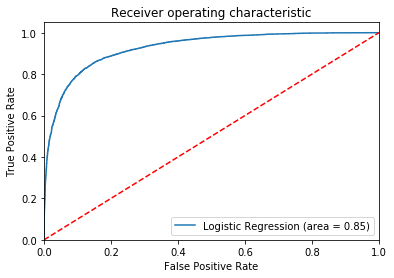

         words    weights
0        great   9.799497
1       highli   9.556715
2        excel   8.088258
3      perfect   7.720519
4         love   7.451315
5         amaz   7.304115
6    complaint   7.204439
7         best   7.058083
8         easi   6.694076
9       awesom   6.394411
10        glad   5.773560
11    conjunct   5.615929
12       worri   5.589637
13        year   5.519067
14      barber   5.299289
15     downsid   5.224434
16        beat   5.158196
17     satisfi   5.144175
18      cayenn   4.964851
19     fantast   4.881596
20        well   4.799798
21       hesit   4.749799
22     without   4.697760
23      confid   4.581084
24        good   4.541791
25  disappoint -10.753410
26      return  -9.003082
27        wast  -8.530579
28    unfortun  -8.461932
29       sadli  -8.087585
30       worst  -7.937769
31       didnt  -7.848692
32   worthless  -7.454389
33       threw  -7.048616
34        noth  -6.851652
35      refund  -6.837973
36        wors  -6.623284
37        ma

In [33]:
import os
import gc
gc.collect()

os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment')

for i in os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment'):
    if i[-len('.json'):] == '.json' and i[-5:] != 'ipynb' and i[-3:] != 'csv' and i == 'Health_and_Personal_Care_5.json': # and i = 'Health_and_Personal_Care_5.json':
        print (i[:-5])
        print ('   ')
        
        
        x,y = prepare_dataset ('/Volumes/GoogleDrive/Мой диск/Work/Experiment/' + i)
        
        classify_it ('/Volumes/GoogleDrive/Мой диск/Work/Experiment/' + i,x,y)
        
        del x
        del y
        
        gc.collect()
        

Comments

https://habr.com/ru/company/ods/blog/323890/#1-lineynaya-regressiya

https://docplayer.ru/28834116-Otchet-po-zadaniyu-4-issledovanie-modeli-logistic-regression.html

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9,_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2)#.D0.9E.D1.81.D0.BD.D0.BE.D0.B2.D0.BD.D1.8B.D0.B5_.D0.BF.D0.BE.D0.BD.D1.8F.D1.82.D0.B8.D1.8F_.D0.B8_.D0.BF.D1.80.D0.B8.D0.BC.D0.B5.D1.80.D1.8B_.D0.BF.D1.80.D0.B8.D0.BA.D0.BB.D0.B0.D0.B4.D0.BD.D1.8B.D1.85_.D0.B7.D0.B0.D0.B4.D0.B0.D1.87



ROC:
https://basegroup.ru/community/articles/logistic

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [ ]:
cv = TfidfVectorizer(min_df=10, decode_error='replace', encoding='utf-8')
X = cv.fit_transform(X_train)
# X_test = cv.transform(X_val)

In [ ]:
X_train = ['hi all', 'all stupid beaches', 'all ']


cv = TfidfVectorizer(min_df=1, decode_error='replace', encoding='utf-8')
X = cv.fit_transform(X_train)

cv.get_feature_names()

In [ ]:
print (X.toarray())